### Traditional segmentation methods

In [13]:
# Importing Libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from tqdm import tqdm

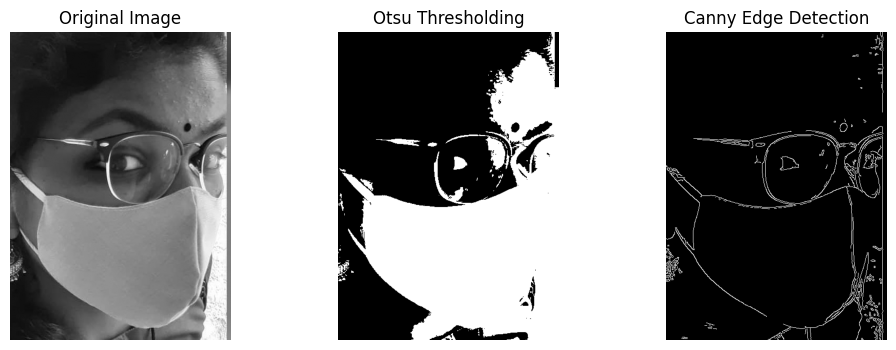

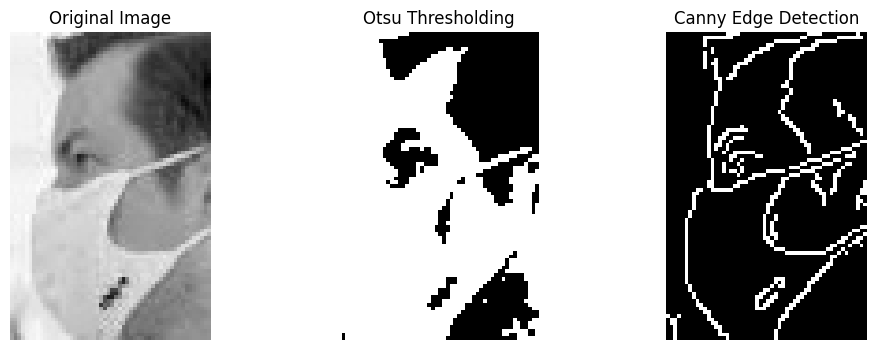

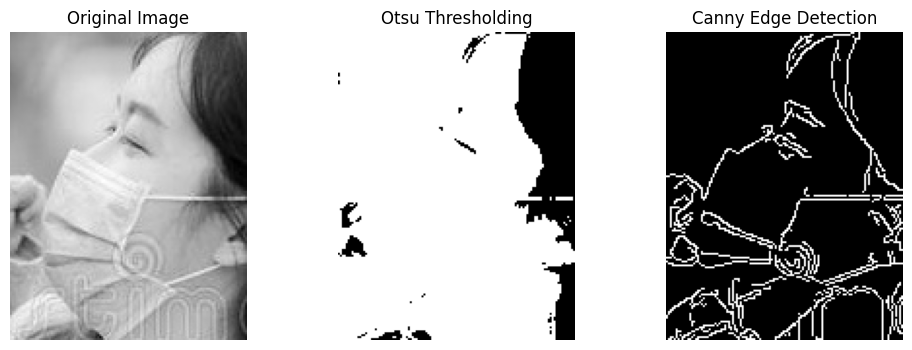

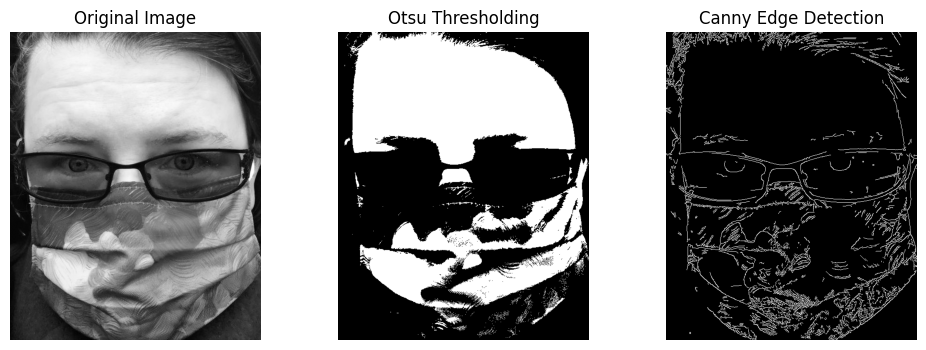

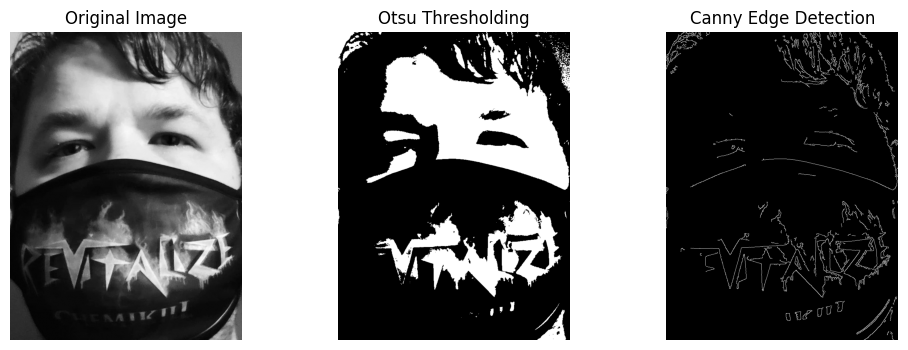

In [14]:
# Define dataset directory
dataset_dir = "MSFD/1/face_crop/"

# Get image files
image_files = [f for f in os.listdir(dataset_dir) if f.endswith(".jpg")]

# Process first few images for visualization
num_images = 5
for i, img_name in enumerate(image_files[:num_images]):
    img_path = os.path.join(dataset_dir, img_name)
    
    # Read image
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    # Apply Otsu's thresholding
    _, mask_thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Apply Canny edge detection
    mask_edges = cv2.Canny(image, 100, 200)
    
    # Visualize results
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(image, cmap="gray")
    axes[0].set_title("Original Image")
    axes[1].imshow(mask_thresh, cmap="gray")
    axes[1].set_title("Otsu Thresholding")
    axes[2].imshow(mask_edges, cmap="gray")
    axes[2].set_title("Canny Edge Detection")
    
    for ax in axes:
        ax.axis("off")
    
    plt.show()


### Via UNET

In [2]:
# Define dataset class
class FaceMaskDataset(Dataset):
    def __init__(self, image_dir, mask_dir=None, transform=None, img_size=(256, 256)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = os.listdir(image_dir)
        self.transform = transform
        self.img_size = img_size
    
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, self.img_size)
        
        if self.mask_dir:
            mask_path = os.path.join(self.mask_dir, self.image_filenames[idx])
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, self.img_size)
            mask = np.expand_dims(mask, axis=0) / 255.0  # Normalize mask
            mask_tensor = torch.tensor(mask, dtype=torch.float32)
        else:
            mask_tensor = torch.zeros((1, *self.img_size), dtype=torch.float32)  # Dummy mask for test data
        
        if self.transform:
            image = self.transform(image)
        
        return image, mask_tensor

In [4]:
# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

# Load dataset
train_dataset = FaceMaskDataset("../VR_Project1_AnukritiSingh_MS2024504/MSFD/1/face_crop", "../VR_Project1_AnukritiSingh_MS2024504/MSFD/1/face_crop_segmentation", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [7]:
# Define U-Net model
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )
        
        self.enc1 = conv_block(3, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)
        self.bottleneck = conv_block(512, 1024)
        
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec1 = conv_block(1024, 512)
        
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec2 = conv_block(512, 256)
        
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec3 = conv_block(256, 128)
        
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec4 = conv_block(128, 64)
        
        self.final = nn.Conv2d(64, 1, kernel_size=1)
        self.pool = nn.MaxPool2d(2)
    
    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        b = self.bottleneck(self.pool(e4))
        
        d1 = self.dec1(torch.cat([self.up1(b), e4], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d1), e3], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d2), e2], dim=1))
        d4 = self.dec4(torch.cat([self.up4(d3), e1], dim=1))
        
        return torch.sigmoid(self.final(d4))

In [12]:
# Initialize model
model = UNet()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

def train(model, dataloader, epochs=10):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")
        for images, masks in progress_bar:
            images, masks = images.float(), masks.float()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            progress_bar.set_postfix(loss=epoch_loss / len(dataloader))

# Train the model
train(model, train_loader, epochs=10)

[ WARN:0@15840.737] global loadsave.cpp:268 findDecoder imread_('../VR_Project1_AnukritiSingh_MS2024504/MSFD/1/face_crop_segmentation/000601_1.jpg'): can't open/read file: check file path/integrity
Epoch 1/10:  98%|█████████████████████████████████████████████████████████████████▋ | 1151/1173 [8:03:13<09:14, 25.19s/it, loss=0.514]


error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'
